<a href="https://colab.research.google.com/github/raphaelgbe/Variational-AutoEncoders/blob/master/vanilla_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE with ELBO objective on MNIST dataset:

In [0]:
import os, sys, math
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import random
import PIL.Image
from torchvision import datasets

seed = 40569
random.seed(seed)
torch.manual_seed(seed)

import torch.nn as nn
import torch.nn.functional as F


In [0]:
batch_size = 200
z_dim = 10
padding = 1
stride = 2
params = {'stride': stride, 'padding': padding}

In [0]:
class Encoder(nn.Module):
    
    def __init__(self, z_dim, batch_size=batch_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 4, **params)
        self.conv2 = nn.Conv2d(64, 128, 4, **params)
        self.fc1 = nn.Linear(7*7*128, 512)
        self.fc2 = nn.Linear(512, z_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.1)
        x = x.view(-1, np.array(x.shape)[1:].prod())
        x = F.leaky_relu(self.fc1(x))
        mean = self.fc2(x)
        stddev = torch.max(self.fc2(x), 0.001 * torch.ones(z_dim))
        return mean, stddev, mean + stddev * torch.randn(z_dim)

In [0]:
class Decoder(nn.Module):
    
    def __init__(self, z_dim, batch_size=batch_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 1024)
        self.fc2 = nn.Linear(1024, 7*7*128)
        self.conv1 = nn.ConvTranspose2d(128, 64, 4, **params)
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, **params)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return F.sigmoid(x)

In [0]:
class VAE(nn.Module):
    
    def __init__(self, image_channels=1, z_dim=z_dim, batch_size=batch_size, elbo_coeff=0.001):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.elbo_coeff = elbo_coeff
        self.encoder = Encoder(z_dim, batch_size)
        self.decoder = Decoder(z_dim, batch_size)
        
    def forward(self, x):
        mu, stddev, z = self.encoder(x)
        if self.training:
            return mu, stddev, self.decoder(z)
        else:
            return self.decoder(z)
    
    def loss_nll(self, x, x_recon):
        return F.mse_loss(x_recon, x) #((x_recon - x)**2).mean()
    
    def loss_elbo(self, mean, stddev):
        return - self.elbo_coeff * (torch.log(stddev) - 0.5 * stddev ** 2 - 0.5 * mean **2 + 0.5).mean()

In [0]:
vae = VAE()

In [0]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [0]:
path = './MNIST_data'
if not os.path.exists(path):
    os.makedirs(path)

data = datasets.MNIST(path, train=True, download=False)

In [0]:
ls_shuffle = list(range(60000))
random.shuffle(ls_shuffle)
split = 0.8

In [0]:
epochs = 2
height = data.train_data.shape[-2]
width = data.train_data.shape[-1]
train_data = data.train_data[ls_shuffle[:math.ceil(split * 60000)]].type('torch.FloatTensor')/255.
val_data = data.train_data[ls_shuffle[math.ceil(split * 60000):]].type('torch.FloatTensor')/255.

In [0]:
nb_batches = len(train_data)//batch_size

for epoch in range(epochs):
    for id_batch in range(nb_batches):
        data_batch = train_data[(batch_size * id_batch):((id_batch + 1) * batch_size)]
        data_batch = data_batch.view(batch_size, 1, height, width)
        mu_batch, stddev_batch, data_batch_recon = vae(data_batch)
        elbo_loss = vae.loss_elbo(mu_batch, stddev_batch)
        nll_loss = vae.loss_nll(data_batch, data_batch_recon)
        loss = nll_loss + elbo_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not id_batch % 10:
            print(f'Epoch {epoch + 1}/{epochs}, Batch {id_batch}/{nb_batches}, Loss ELBO: {elbo_loss}; Loss NLL: {nll_loss}')

C:\Users\Raphael\Anaconda3bis\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/2, Batch 0/240, Loss ELBO: 0.0047979517839848995; Loss NLL: 0.22729434072971344
Epoch 1/2, Batch 10/240, Loss ELBO: 0.0013726052129641175; Loss NLL: 0.08200478553771973
Epoch 1/2, Batch 20/240, Loss ELBO: 0.0016000468749552965; Loss NLL: 0.0680796205997467
Epoch 1/2, Batch 30/240, Loss ELBO: 0.0013110506115481257; Loss NLL: 0.066672183573246
Epoch 1/2, Batch 40/240, Loss ELBO: 0.0012378502869978547; Loss NLL: 0.06675736606121063
Epoch 1/2, Batch 50/240, Loss ELBO: 0.0016925105592235923; Loss NLL: 0.06311330199241638
Epoch 1/2, Batch 60/240, Loss ELBO: 0.0013989669969305396; Loss NLL: 0.06381028145551682
Epoch 1/2, Batch 70/240, Loss ELBO: 0.0014490534085780382; Loss NLL: 0.06150618568062782
Epoch 1/2, Batch 80/240, Loss ELBO: 0.0011145849712193012; Loss NLL: 0.06281176209449768
Epoch 1/2, Batch 90/240, Loss ELBO: 0.0011050724424421787; Loss NLL: 0.06215488538146019
Epoch 1/2, Batch 100/240, Loss ELBO: 0.0012572905980050564; Loss NLL: 0.059486161917448044
Epoch 1/2, Batch 110/24

C:\Users\Raphael\Anaconda3bis\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


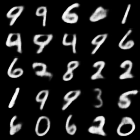

In [0]:
import PIL.Image

sqrt_ex = 5

arr = np.zeros((sqrt_ex * 28, sqrt_ex * 28), dtype='uint8')

for i in range(sqrt_ex):
    for j in range(sqrt_ex):
        arr[i*28:(i+1)*28, j*28:(j+1)*28] = ((vae(val_data[i + 5*j].view(1, 1, height, width)))[-1]*255.).type('torch.IntTensor').view(28, 28).numpy().astype('uint8')

#print(type(arr), arr.shape, arr.dtype)
PIL.Image.fromarray(arr, 'L')


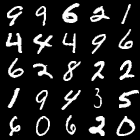

In [0]:
or_arr = np.zeros((sqrt_ex * 28, sqrt_ex * 28), dtype='uint8')

for i in range(sqrt_ex):
    for j in range(sqrt_ex):
        or_arr[i*28:(i+1)*28, j*28:(j+1)*28] = (val_data[i + 5*j]*255.).type('torch.IntTensor').numpy().astype('uint8')
        
PIL.Image.fromarray(or_arr, 'L')

In [0]:
z_test_rand = torch.randn(z_dim)

In [0]:
gen_arr_test = (vae.decoder(z_test_rand)*255).type('torch.IntTensor').view(28, 28).numpy().astype('uint8')

C:\Users\Raphael\Anaconda3bis\lib\site-packages\torch\nn\functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
PIL.Image.fromarray(gen_arr_test, 'L')